In [1]:
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
print('imported numpy and astropy', flush=True)
from galpy.df import streamdf
from galpy.orbit import Orbit
from galpy.actionAngle import actionAngleIsochroneApprox
from galpy.util import conversion #for unit conversions
from galpy.util.conversion import get_physical
print('imported galpy', flush=True)
from galpy.potential.mwpotentials import MWPotential2014
print('imported MW14 potential', flush=True)

imported numpy and astropy
A new version of galpy (1.8.2) is available, please upgrade using pip/conda/... to get the latest features and bug fixes!
imported galpy
imported MW14 potential


In [2]:
# Potential
Potential = MWPotential2014
ro = get_physical(MWPotential2014)['ro']
vo = get_physical(MWPotential2014)['vo']

In [3]:
np.random.seed(1)

# define progenitors: Orbit instances (R,vR,vT,Z,vZ,ϕ)
l=40
n=5
v = 100
Gyrs = np.random.uniform(2,5,n)
phis = np.random.uniform(0,360,n)*u.deg
Rs  = np.random.uniform(15,l,n)*u.kpc
Zs  = np.random.uniform(-l,l,n)*u.kpc
vRs = np.random.uniform(-v,v,n)*u.km/u.s
vTs = np.random.uniform(-v,0,n)*u.km/u.s
vZs = np.random.uniform(-v,v,n)*u.km/u.s

# action angle instance
aAI= actionAngleIsochroneApprox(pot=Potential,b=0.5)

os = []
sdfs = []
j = 0
for i in np.arange(n): 
    try:
        o = Orbit([Rs[i],vRs[i],vTs[i],Zs[i],vZs[i],phis[i]])
        # instantiate the streamdf model
        sigv= 0.365/vo
        print('test', flush=True)
        sdf= streamdf(sigv,progenitor=o,pot=Potential,aA=aAI,leading=True,nTrackChunks=11,tdisrupt=Gyrs[i]/conversion.time_in_Gyr(vo,ro))
        os.append(o)
        sdfs.append(sdf)
        print(i,': yes', flush=True)
        print(np.sqrt(Rs[i]**2+Zs[i]**2),np.sqrt(vRs[i]**2+vTs[i]**2+vZs[i]**2), Gyrs[i], flush=True)
        j = j+1
        if j>=3:
                break
    except:
        print(i,': nah', flush=True)

test
0 : yes
28.899863534932415 kpc 100.90579771732007 km / s 3.251066014107722
test
1 : yes
32.80449054899215 kpc 131.8755373698313 km / s 4.160973480326474
test
2 : yes
20.652104323154568 kpc 137.88796706368575 km / s 2.0003431244520344


In [30]:
N = j
# rows represent streams, columns: star within stream 
x  = np.empty((N, 50))
y  = np.empty((N, 50))
z  = np.empty((N, 50))
E  = np.empty((N, 50))
Lz = np.empty((N, 50))
L  = np.empty((N, 50))
e  = np.empty((N, 50))

for i in np.arange(N):
    RvR= sdfs[i].sample(n=50)
    stream = Orbit(RvR.T)
    x[i,:] = stream.x()
    y[i,:] = stream.y()
    z[i,:] = stream.z()

    E[i,:] = stream.E(pot=Potential)
    Lz[i,:] = stream.Lz()
    L[i,:] = np.sqrt(np.sum(stream.L()**2, axis=1))
    e[i,:]  = stream.e(pot = Potential, analytic=True, type= 'staeckel')

E_fl = E.flatten()
Lz_fl = Lz.flatten()
L_fl = L.flatten()
e_fl = e.flatten()
x_fl = x.flatten()
y_fl = y.flatten()
z_fl = z.flatten()

a = np.zeros(50)
b = np.ones(50)
c = 2*np.ones(50)
d = np.array((a,b,c))
d_fl = d.flatten()
d_fl

Data = np.array((x_fl, y_fl, z_fl, E_fl, Lz_fl, L_fl, e_fl, d_fl)).T
np.random.shuffle(Data)
print(Data.shape, Data)
np.savetxt('MW14sim2streams_xyz_E_Lz_L_e.csv',Data, delimiter=',')

print('done')


(150, 8) [[ 2.76460288  1.79002284  1.41385466 ...  1.63128901  0.52583484
   0.        ]
 [ 1.78094167  3.73159189 -0.77138778 ...  1.69997488  0.6391999
   1.        ]
 [-1.23326878  2.06337858  0.74173066 ...  1.58082689  0.34509238
   2.        ]
 ...
 [-1.1659532   2.05764975  0.81051011 ...  1.57746528  0.34617601
   2.        ]
 [ 1.98511309  3.78446953 -0.69502033 ...  1.70226922  0.639557
   1.        ]
 [ 1.70743372  3.71509423 -0.76031069 ...  1.69947451  0.63999681
   1.        ]]
done


In [3]:
Data = np.loadtxt('MW14sim2streams_xyz_E_Lz_L_e.csv', delimiter=',')
XYZ = Data[:,:3]
mask0 =  Data[:,7] == 0
mask1 =  Data[:,7] == 1
mask2 =  Data[:,7] == 2
data = Data[:,3:7]
clust1 = data[mask0]
clust2 = data[mask1]
clust3 = data[mask2]

Text(0.5, 0, 'galactocentric Z')

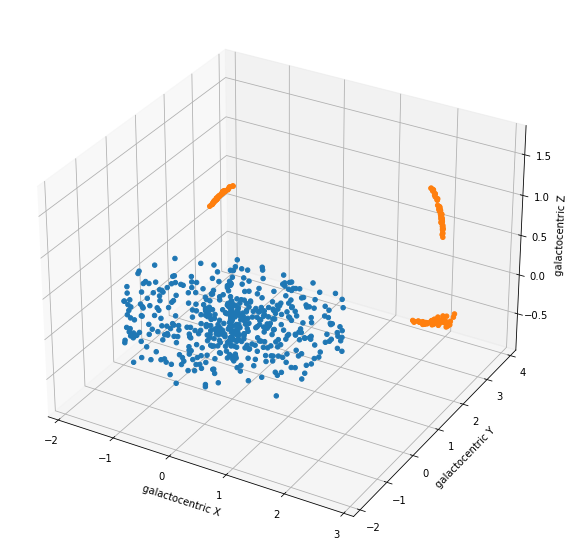

In [7]:
%matplotlib inline 
plt.rcParams.update({'font.size':10})
fig=plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')


# representing the disk of galaxy
phiDisk = np.random.uniform(0,360,500)
RDisk  = np.random.uniform(0,15,500)/ro
ZDisk  = np.random.uniform(-2,2,500)/ro

XDisk, YDisk = RDisk*np.cos(phiDisk), RDisk*np.sin(phiDisk)
ax.scatter(XDisk,YDisk,ZDisk, alpha=1)
ax.scatter(XYZ[:,0],XYZ[:,1],XYZ[:,2],alpha=1)

ax.set_xlabel('galactocentric X')
ax.set_ylabel('galactocentric Y')
ax.set_zlabel('galactocentric Z')

In [7]:
def plotClust(clust1):
    ax[0][0].scatter(clust1[:,1], clust1[:,0])
    ax[0][1].scatter(clust1[:,1], clust1[:,2])
    ax[0][2].scatter(clust1[:,3], clust1[:,1])
    ax[1][0].scatter(clust1[:,2], clust1[:,0])
    ax[1][1].scatter(clust1[:,3], clust1[:,2])
    ax[1][2].scatter(clust1[:,3], clust1[:,0])
def plotClust2(clust1, color):
    ax[0][0].scatter(clust1[:,1], clust1[:,0], c=color)
    ax[0][1].scatter(clust1[:,1], clust1[:,2], c=color)
    ax[0][2].scatter(clust1[:,3], clust1[:,1], c=color)
    ax[1][0].scatter(clust1[:,2], clust1[:,0], c=color)
    ax[1][1].scatter(clust1[:,3], clust1[:,2], c=color)
    ax[1][2].scatter(clust1[:,3], clust1[:,0], c=color)

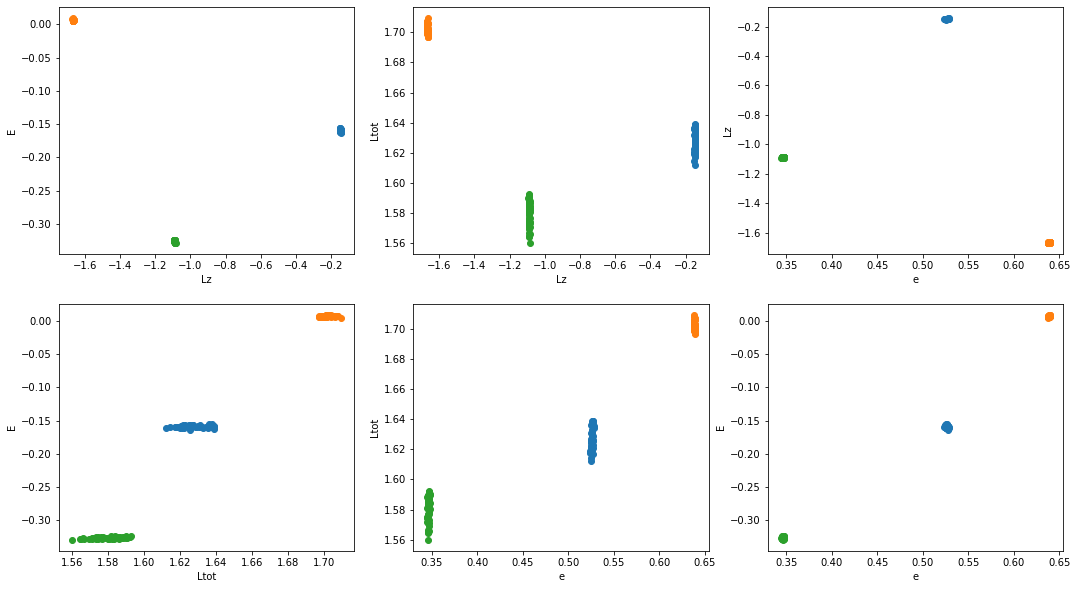

In [8]:
%matplotlib inline
plt.rcParams.update({'font.size':10})
fig, ax = plt.subplots(2, 3, figsize=(18,10))

plotClust(clust1)
plotClust(clust2)
plotClust(clust3)

ax[0][0].set_xlabel('Lz')
ax[0][1].set_xlabel('Lz')
ax[0][2].set_xlabel('e')
ax[1][0].set_xlabel('Ltot')
ax[1][1].set_xlabel('e')
ax[1][2].set_xlabel('e')

ax[0][0].set_ylabel('E')
ax[0][1].set_ylabel('Ltot')
ax[0][2].set_ylabel('Lz')
ax[1][0].set_ylabel('E')
ax[1][1].set_ylabel('Ltot')
ax[1][2].set_ylabel('E');


In [9]:
# Single Linkage Method
n_SL = [0.006,  0.007,0.72,   0.73]
for i in n_SL:
        DTresh = i
        SLclustering = AgglomerativeClustering(n_clusters=None, linkage='single', distance_threshold=DTresh).fit(data)
        SL_labels = SLclustering.labels_
        string = 'Sim_SL_labels'+str(DTresh)+'.csv'
        np.savetxt(string,SL_labels , delimiter=',')

0.006


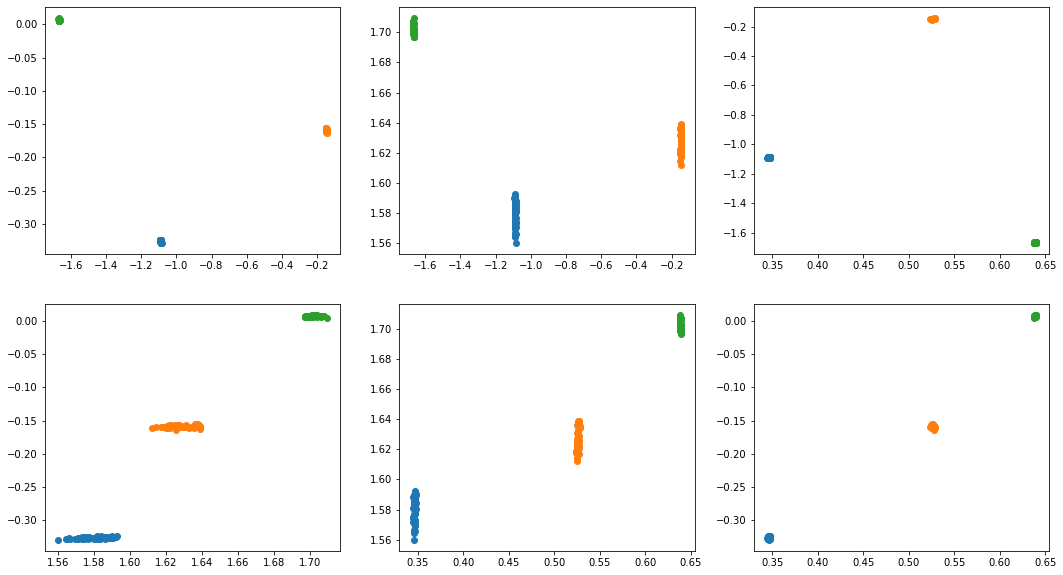

0.007


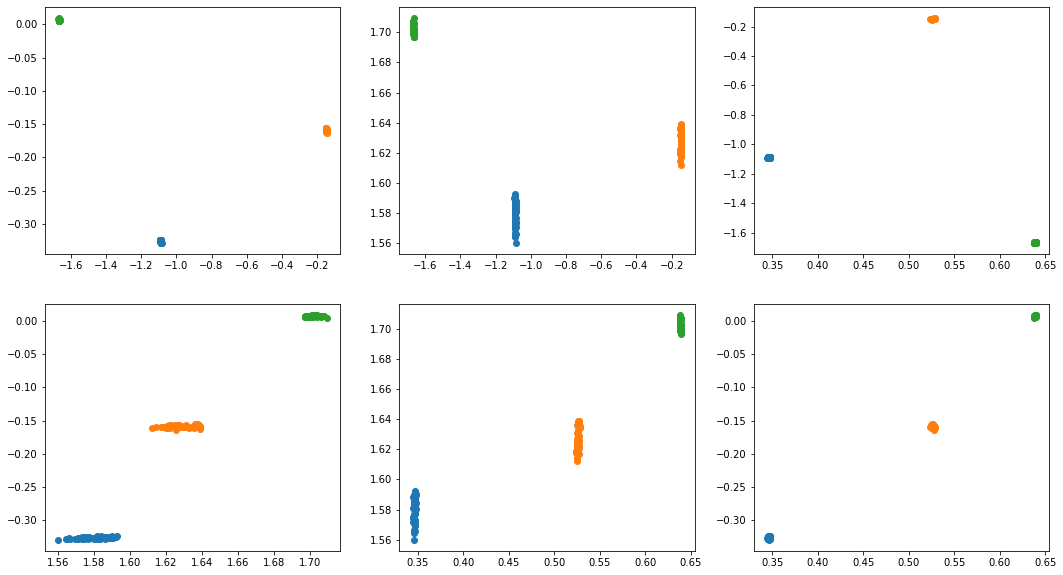

0.72


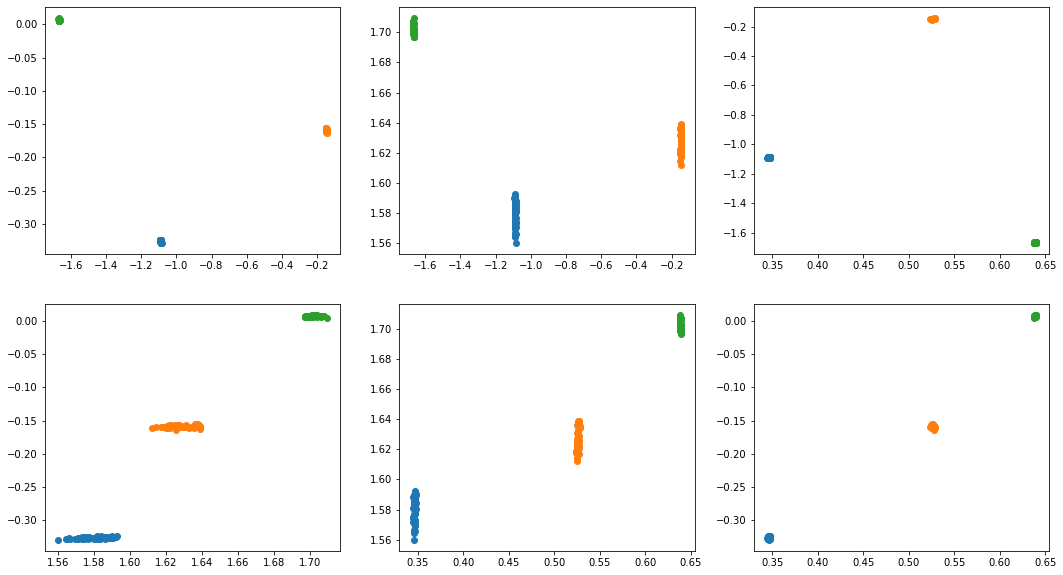

0.73


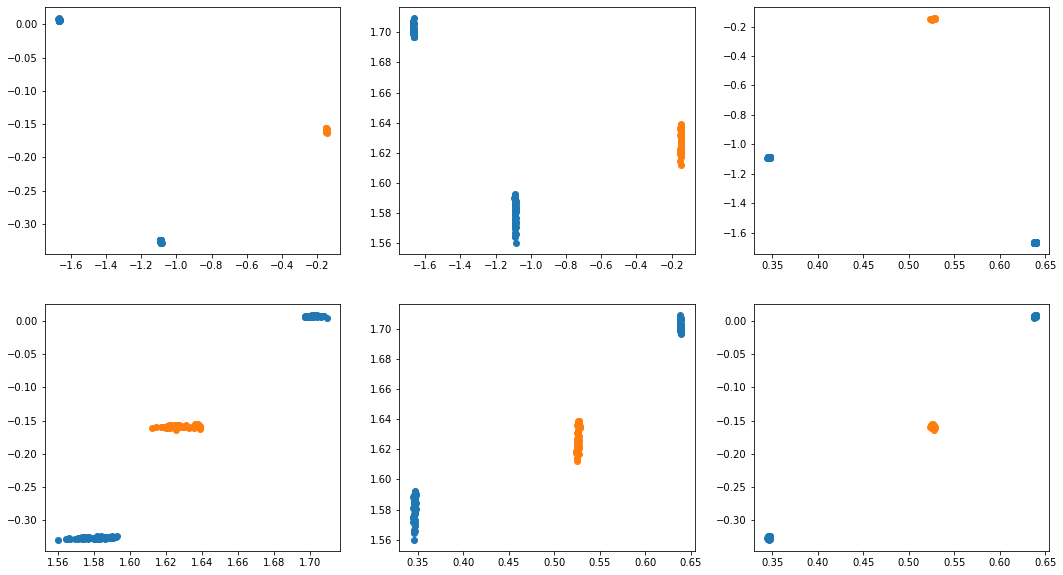

In [10]:
# Single Linkage Method Results
for i in n_SL:
        DTresh = i
        print(DTresh)
        string = 'Sim_SL_labels'+str(DTresh)+'.csv'
        SL_labels = np.loadtxt(string , delimiter=',')
        mx = np.max(SL_labels)
        plt.rcParams.update({'font.size':10})
        fig, ax = plt.subplots(2, 3, figsize=(18,10))
        for i in np.arange(mx+1):
            mask = (SL_labels == i)
            plotClust(data[mask])
        plt.show()

In [11]:
# Ward Method
n_W = [0.06,  0.07,5.2,  5.3]
for i in  n_W :
        DTresh = i
        Wclustering = AgglomerativeClustering(n_clusters=None, linkage='ward', distance_threshold=DTresh).fit(data)
        Ward_labels = Wclustering.labels_
        string = 'Sim_Ward_labels'+str(DTresh)+'.csv'
        np.savetxt(string, Ward_labels , delimiter=',')

0.06


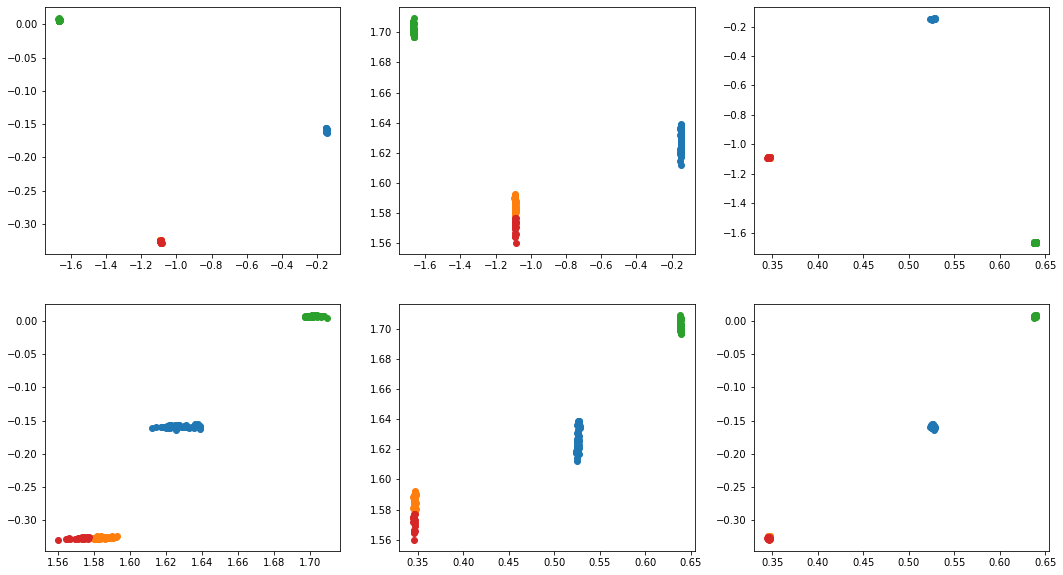

0.07


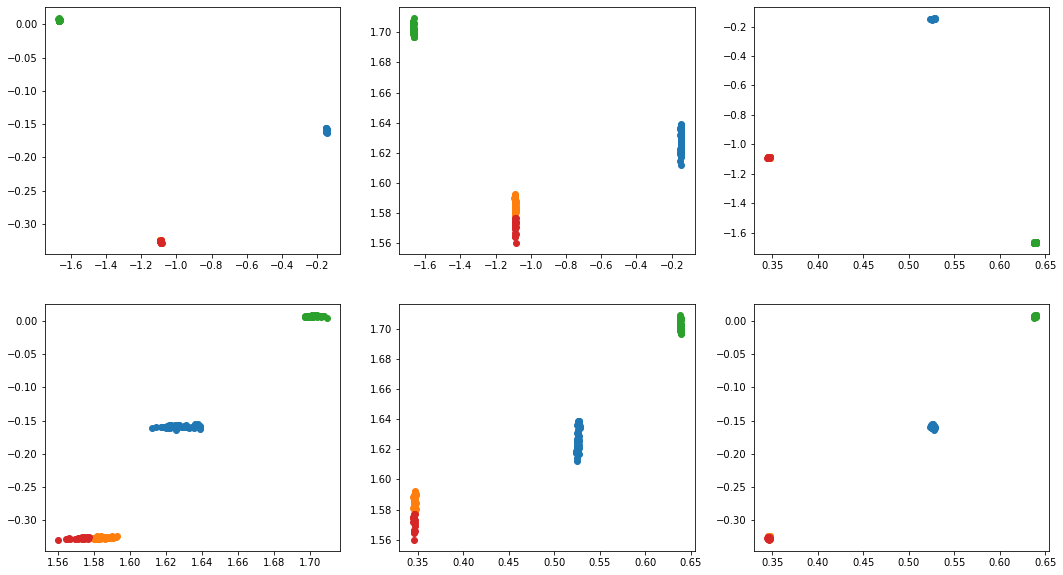

5.2


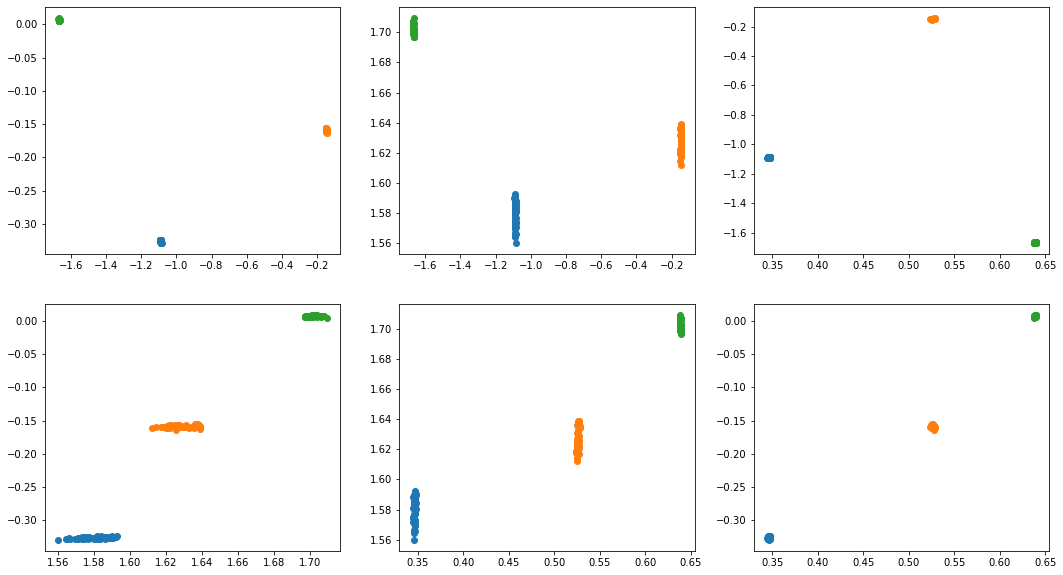

5.3


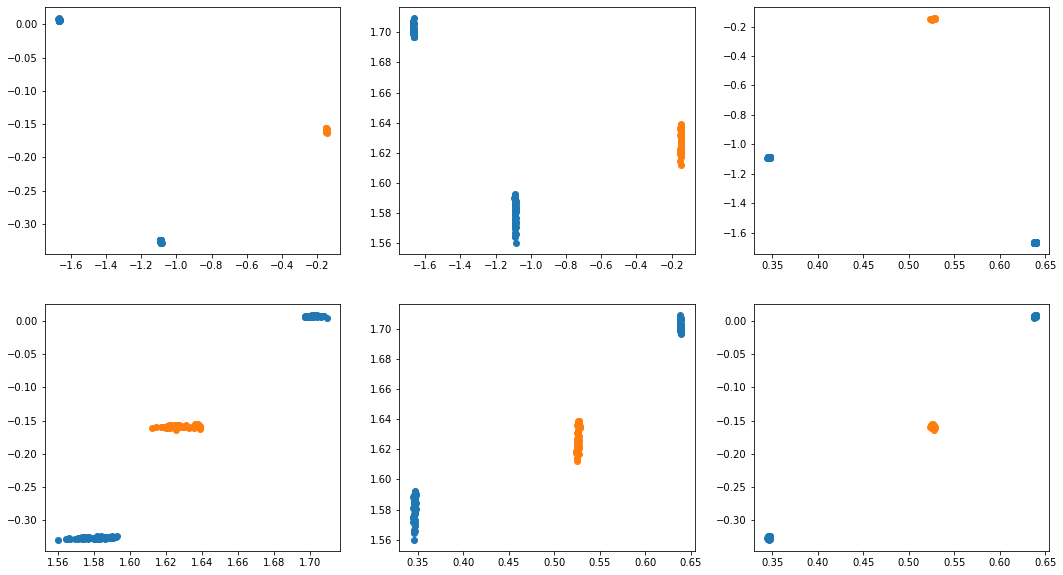

In [12]:
# Ward Method Results
for i in n_W :
        DTresh = i
        print(DTresh)
        string = 'Sim_Ward_labels'+str(DTresh)+'.csv'
        W_labels = np.loadtxt(string , delimiter=',')
        mx = np.max(W_labels)
        plt.rcParams.update({'font.size':10})
        fig, ax = plt.subplots(2, 3, figsize=(18,10))
        for i in np.arange(mx+1):
            mask = (W_labels == i)
            plotClust(data[mask])
        plt.show()

In [13]:
# DBScan Method
n_DB = [0.006,0.01,0.7,0.8]
for i in n_DB:
        eps = i
        db = DBSCAN(eps=eps, min_samples=20).fit(data)
        DB_labels = db.labels_
        string = 'Sim_DB_labels'+str(eps)+'.csv'
        np.savetxt(string, DB_labels , delimiter=',')

0.006


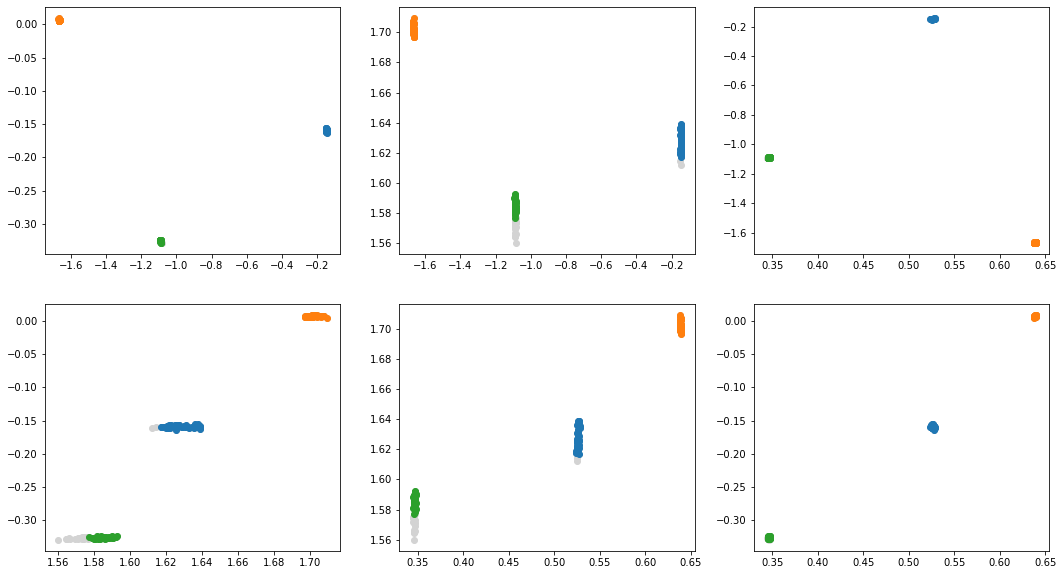

0.01


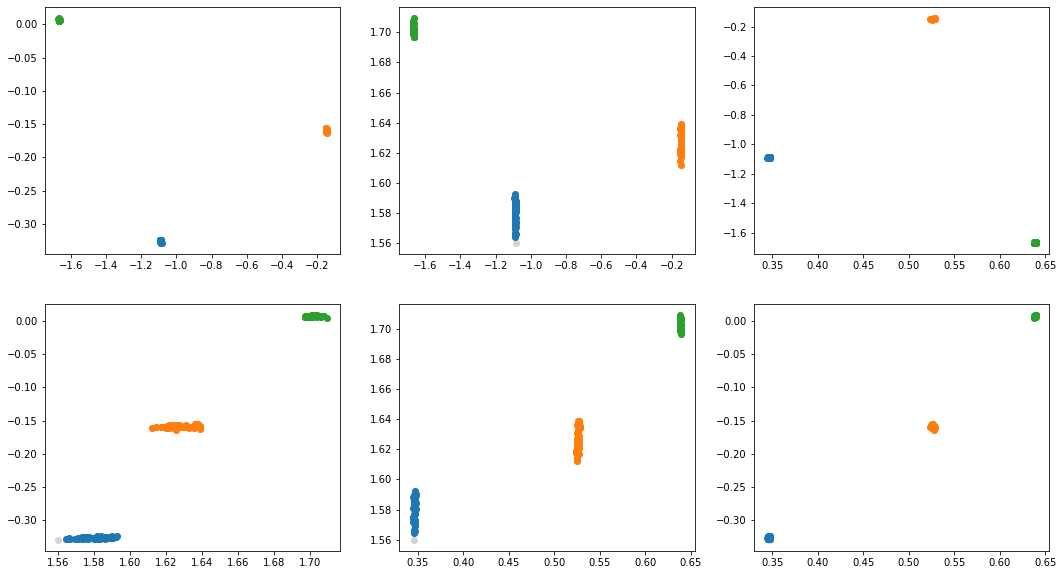

0.7


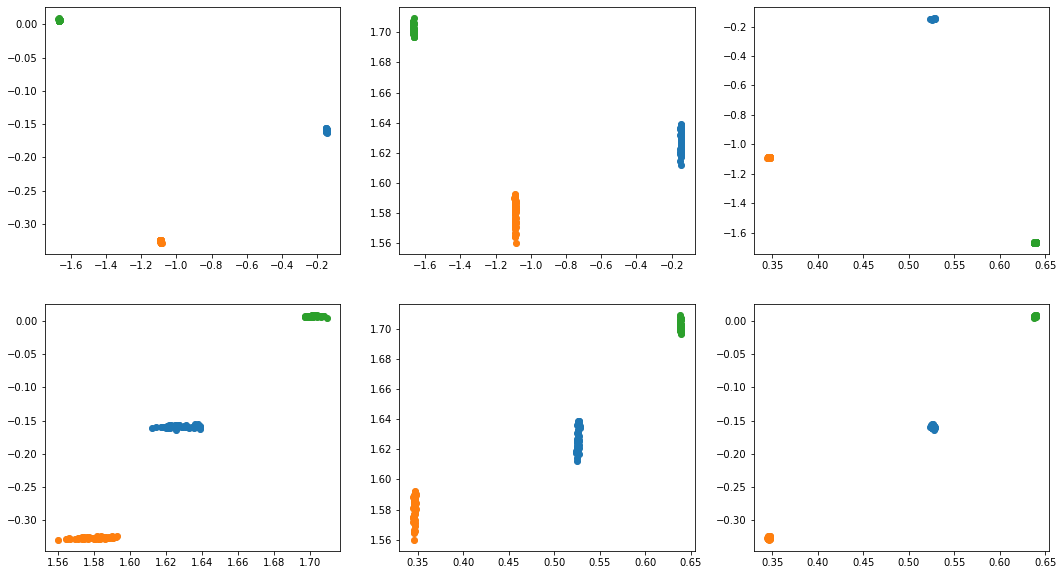

0.8


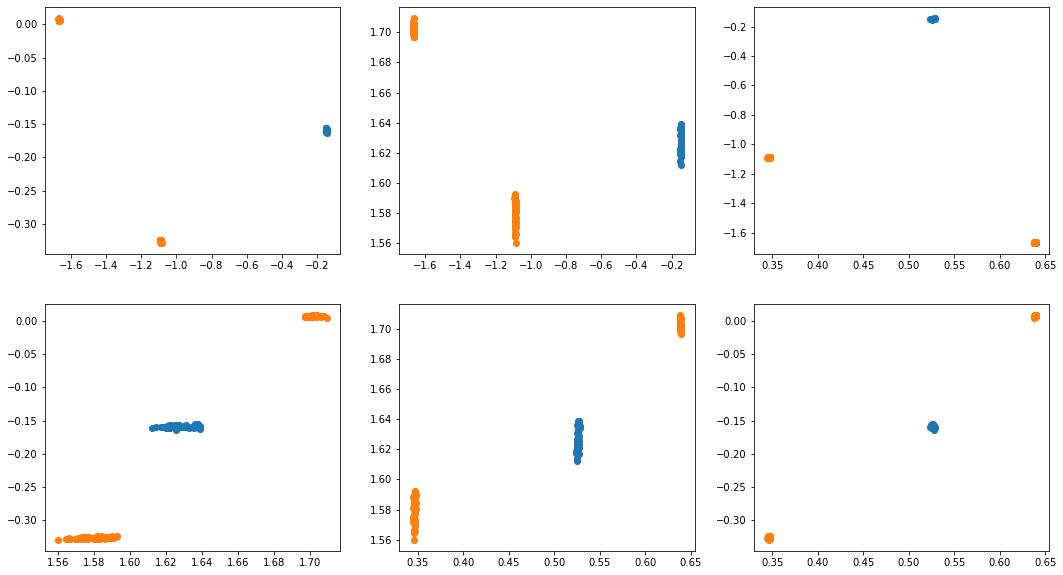

In [14]:
# DBScan Method Results
for i in n_DB:
        eps = i
        print(eps)
        string = 'Sim_DB_labels'+str(eps)+'.csv'
        DB_labels = np.loadtxt(string , delimiter=',')
        mx = np.max(DB_labels)
        plt.rcParams.update({'font.size':10})
        fig, ax = plt.subplots(2, 3, figsize=(18,10))
        plotClust2(data, 'lightgrey')
        for i in np.arange(mx+1):
            mask = (DB_labels == i)
            plotClust(data[mask])
        plt.show()

In [15]:
# OPTICS Method
n_opt= [0.001,0.1,0.5,0.6,0.7,0.8,0.9,0.99]
for i in n_opt:
        xi = i
        opt = OPTICS(xi=xi, min_samples=20).fit(data)
        OPT_labels = opt.labels_
        string = 'Sim_OPT_labels'+str(xi)+'.csv'
        np.savetxt(string, OPT_labels , delimiter=',')

0.001


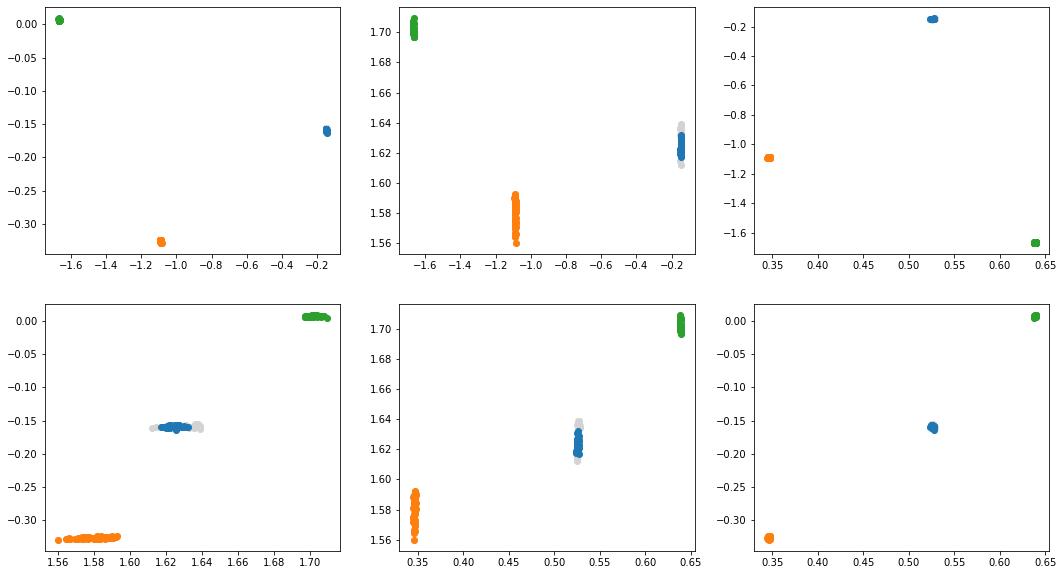

0.1


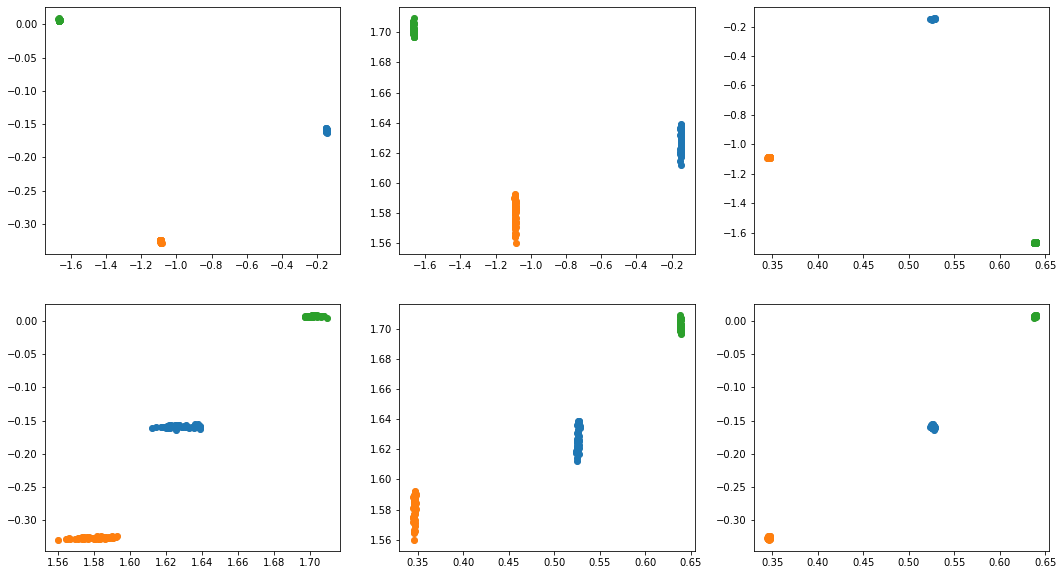

0.5


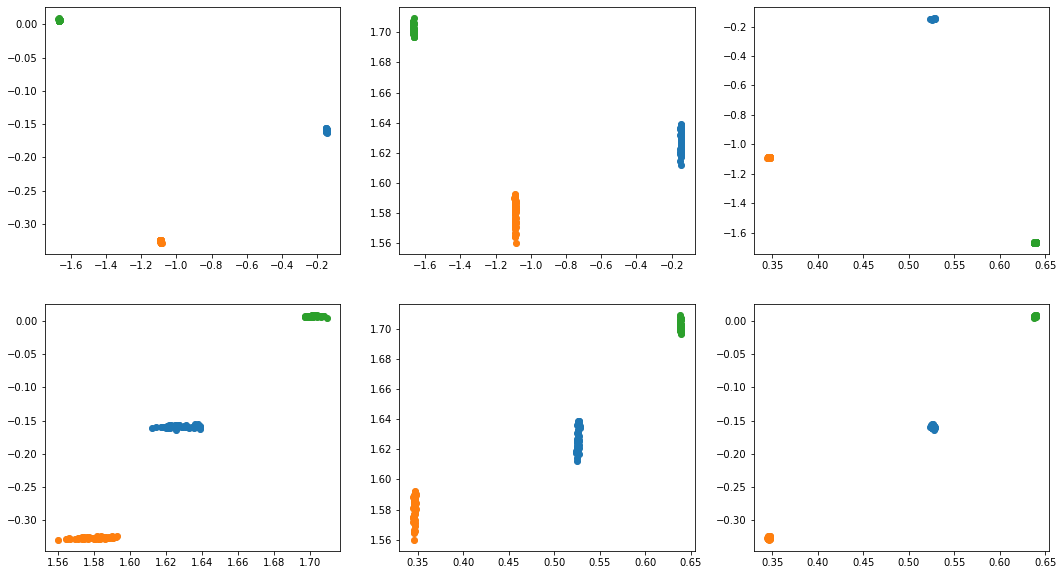

0.6


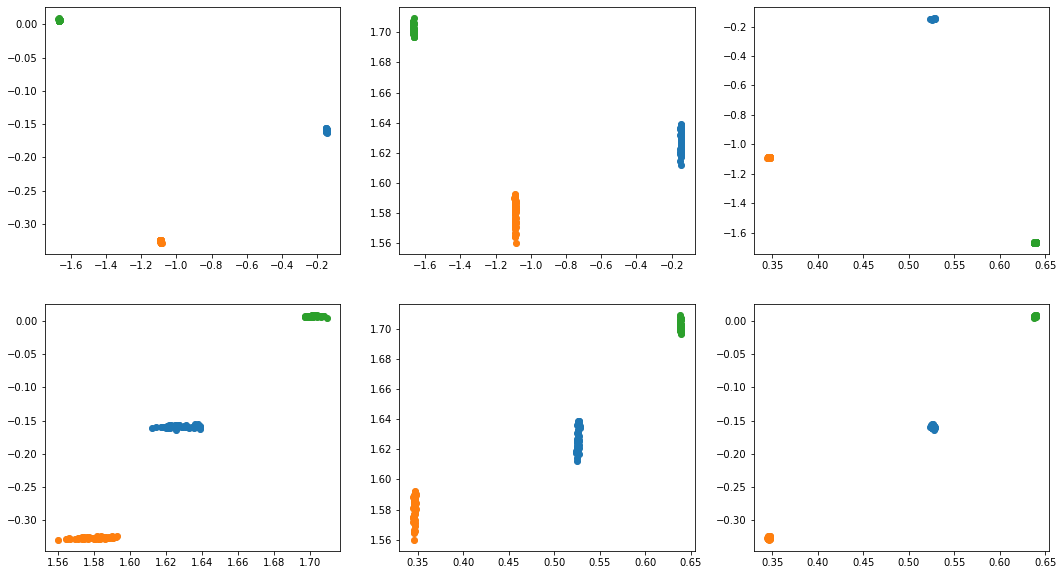

0.7


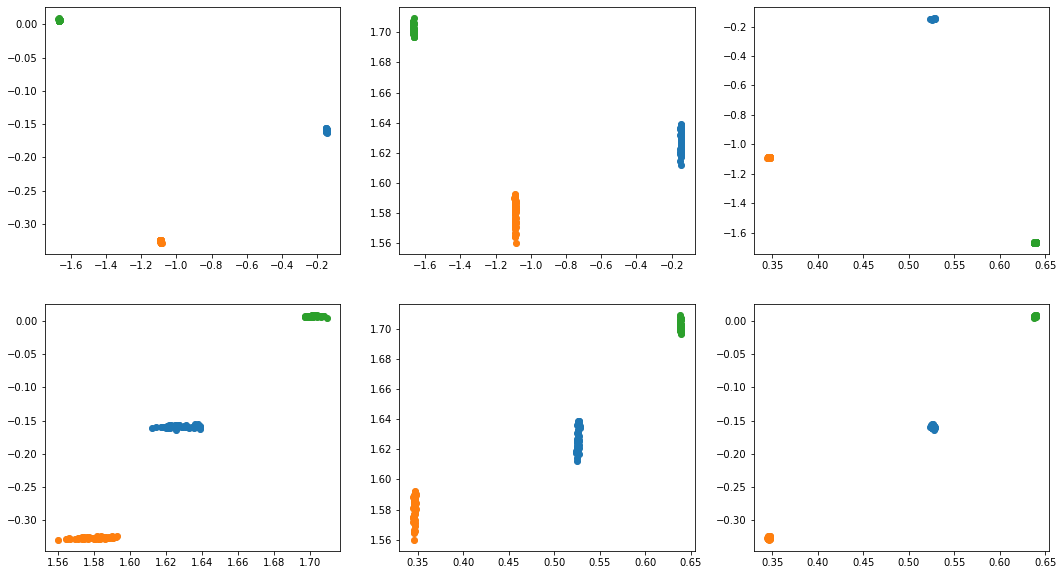

0.8


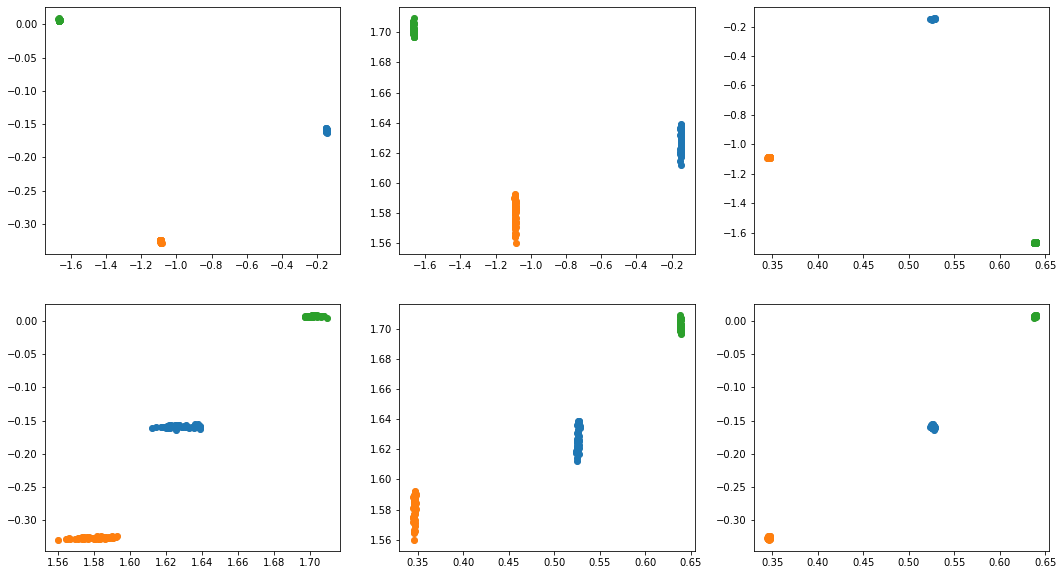

0.9


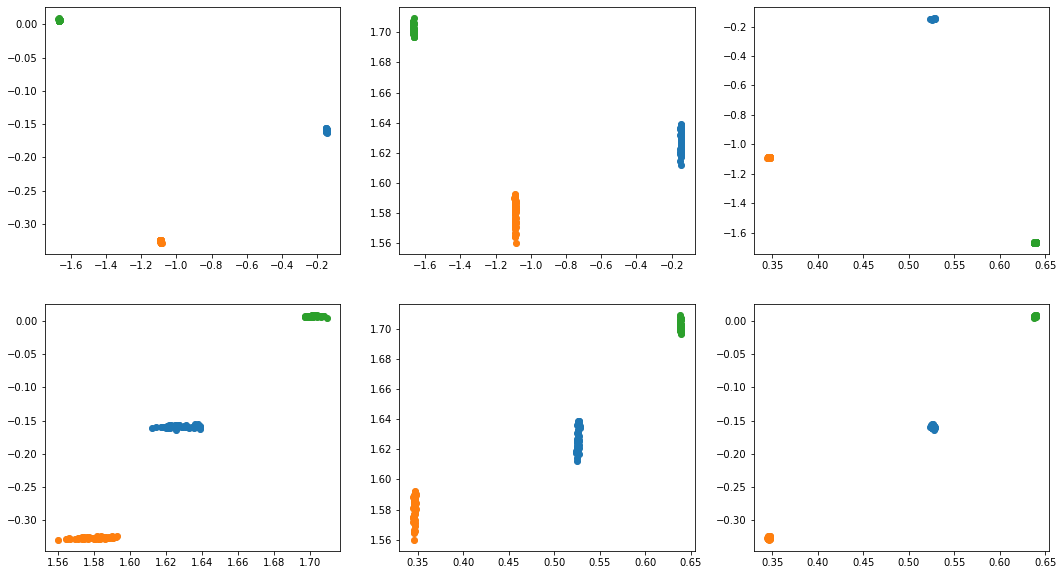

0.99


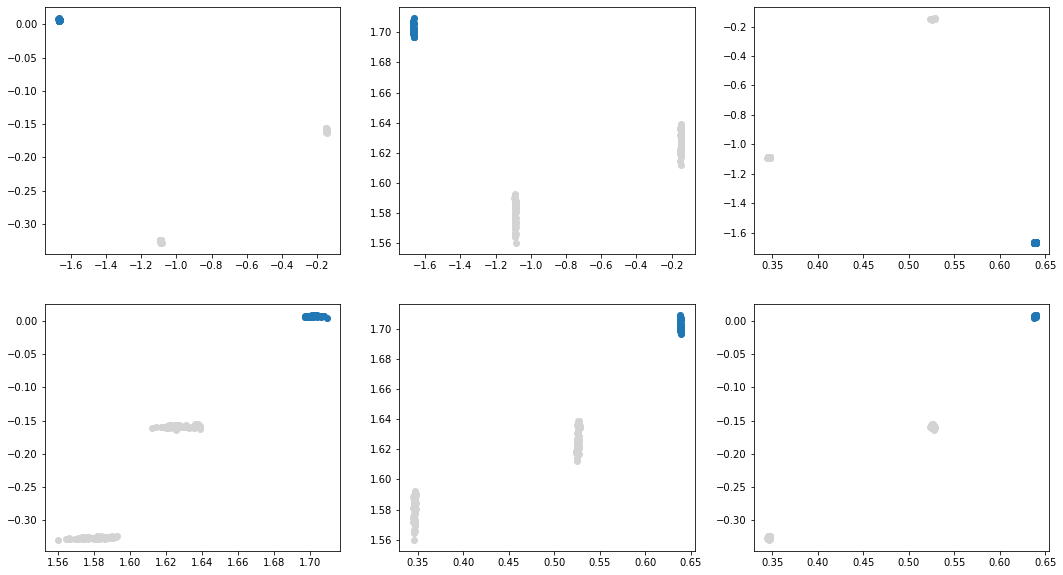

In [16]:
# OPTICS Method Results
for i in n_opt:
        xi = i
        print(xi)
        string = 'Sim_OPT_labels'+str(xi)+'.csv'
        OPT_labels = np.loadtxt(string , delimiter=',')
        mx = np.max(OPT_labels)
        plt.rcParams.update({'font.size':10})
        fig, ax = plt.subplots(2, 3, figsize=(18,10))
        plotClust2(data, 'lightgrey')
        for i in np.arange(mx+1):
            mask = (OPT_labels == i)
            plotClust(data[mask])
        plt.show()

In [17]:
E_scr0  = np.loadtxt('E_scrambled.csv', delimiter=',')
Lz_scr0 = np.loadtxt('Lz_scrambled.csv', delimiter=',')
L_scr0  = np.loadtxt('L_scrambled.csv', delimiter=',')
e_scr0  = np.loadtxt('e_scrambled.csv', delimiter=',')

# new (to select a subset of the size of the real data)
datatemp= np.array((E_scr0, Lz_scr0, L_scr0, e_scr0)).T
np.random.shuffle(datatemp)
E_scr = (datatemp.T[0,:])[0:202450]
Lz_scr= (datatemp.T[1,:])[0:202450]
L_scr = (datatemp.T[2,:])[0:202450]
e_scr = (datatemp.T[3,:])[0:202450]
# end of new
isstream_scr = -1*np.ones(len(e_scr))

Es  = np.append(data[:,0], E_scr)
Lzs = np.append(data[:,1], Lz_scr)
Ls  = np.append(data[:,2], L_scr)
es  = np.append(data[:,3], e_scr)
isstream = np.append(Data[:,7], isstream_scr)

DatawBack = np.array((Es, Lzs, Ls, es, isstream)).T
np.random.shuffle(DatawBack)
np.savetxt('3streamsNbackground_E_Lz_L_e_label.csv',DatawBack, delimiter=',')

In [18]:
DatawBack  = np.loadtxt('3streamsNbackground_E_Lz_L_e_label.csv', delimiter=',')

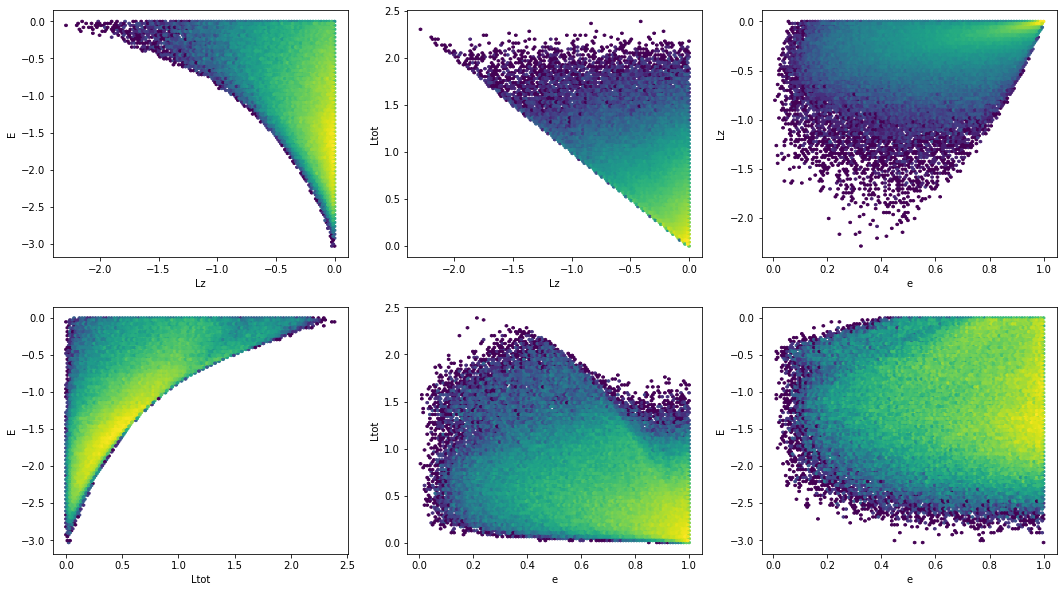

In [19]:
%matplotlib inline 
plt.rcParams.update({'font.size':10})
fig, ax = plt.subplots(2, 3, figsize=(18,10))

maskB = DatawBack[:,4] == -1
background = DatawBack[maskB]

ax[0][0].hexbin(background[:,1], background[:,0], bins='log')
ax[0][1].hexbin(background[:,1], background[:,2], bins='log')
ax[0][2].hexbin(background[:,3], background[:,1], bins='log')
ax[1][0].hexbin(background[:,2], background[:,0], bins='log')
ax[1][1].hexbin(background[:,3], background[:,2], bins='log')
ax[1][2].hexbin(background[:,3], background[:,0], bins='log')

ax[0][0].set_xlabel('Lz')
ax[0][1].set_xlabel('Lz')
ax[0][2].set_xlabel('e')
ax[1][0].set_xlabel('Ltot')
ax[1][1].set_xlabel('e')
ax[1][2].set_xlabel('e')

ax[0][0].set_ylabel('E')
ax[0][1].set_ylabel('Ltot')
ax[0][2].set_ylabel('Lz')
ax[1][0].set_ylabel('E')
ax[1][1].set_ylabel('Ltot')
ax[1][2].set_ylabel('E');


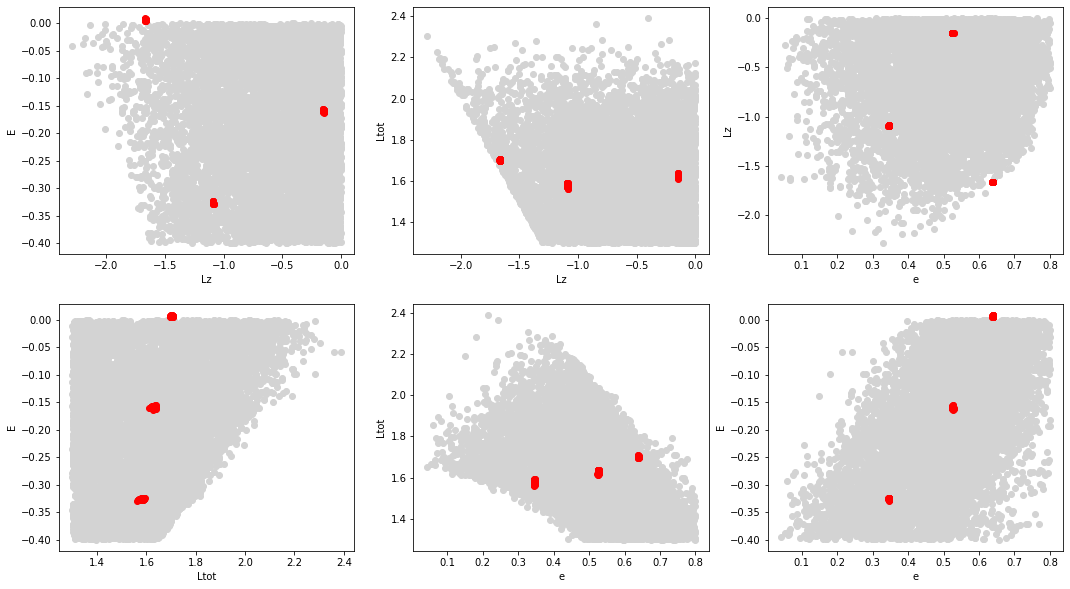

In [20]:
DatawBack  = np.loadtxt('3streamsNbackground_E_Lz_L_e_label.csv', delimiter=',')

%matplotlib inline 
plt.rcParams.update({'font.size':10})
fig, ax = plt.subplots(2, 3, figsize=(18,10))

maskB = DatawBack[:,4] == -1
background = DatawBack[maskB]

maskB1 = background[:,0]>-0.4
maskB2 = background[:,2]> 1.3
maskB3 = background[:,3]<0.8

background[maskB1]
BG = background[maskB1 & maskB2 & maskB3]
           
# ax[0][0].hexbin(BG[:,1], BG[:,0], bins='log')
# ax[0][1].hexbin(BG[:,1], BG[:,2], bins='log')
# ax[0][2].hexbin(BG[:,3], BG[:,1], bins='log')
# ax[1][0].hexbin(BG[:,2], BG[:,0], bins='log')
# ax[1][1].hexbin(BG[:,3], BG[:,2], bins='log')
# ax[1][2].hexbin(BG[:,3], BG[:,0], bins='log')
plotClust2(BG, 'lightgrey')

color = ['r', 'r', 'r']
for i in np.arange(3):
    mask = DatawBack[:,4] == i
    plotClust2(DatawBack[mask], color[i])

ax[0][0].set_xlabel('Lz')
ax[0][1].set_xlabel('Lz')
ax[0][2].set_xlabel('e')
ax[1][0].set_xlabel('Ltot')
ax[1][1].set_xlabel('e')
ax[1][2].set_xlabel('e')

ax[0][0].set_ylabel('E')
ax[0][1].set_ylabel('Ltot')
ax[0][2].set_ylabel('Lz')
ax[1][0].set_ylabel('E')
ax[1][1].set_ylabel('Ltot')
ax[1][2].set_ylabel('E');


In [21]:
maskC = DatawBack[:,4] != -1
Clusters = DatawBack[maskC]
maskB = DatawBack[:,4] == -1
background = DatawBack[maskB]
data2 = np.append(BG,Clusters, axis=0)
np.random.shuffle(data2)
dataWB = data2[:,0:4]

In [22]:
# Single Linkage Method
n_SL = [0.05, 0.06,0.07,0.08,0.09,0.1]
for i in n_SL:
        DTresh = i
        SLclustering = AgglomerativeClustering(n_clusters=None, linkage='single', distance_threshold=DTresh).fit(dataWB)
        SL_labels = SLclustering.labels_
        string = 'SimWB_SL_labels'+str(DTresh)+'.csv'
        np.savetxt(string,SL_labels , delimiter=',')

0.05
709.0


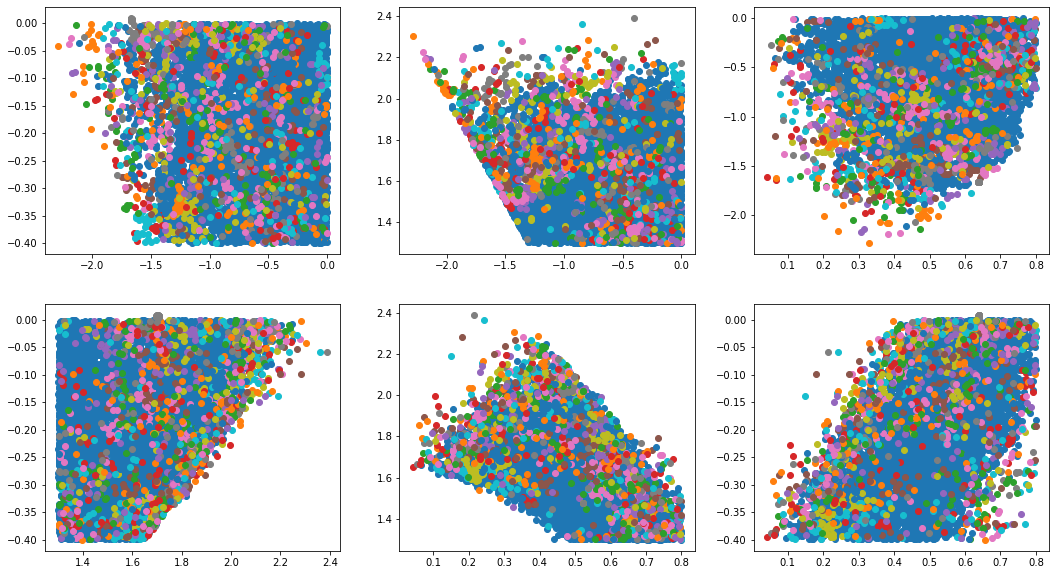

0.06
244.0


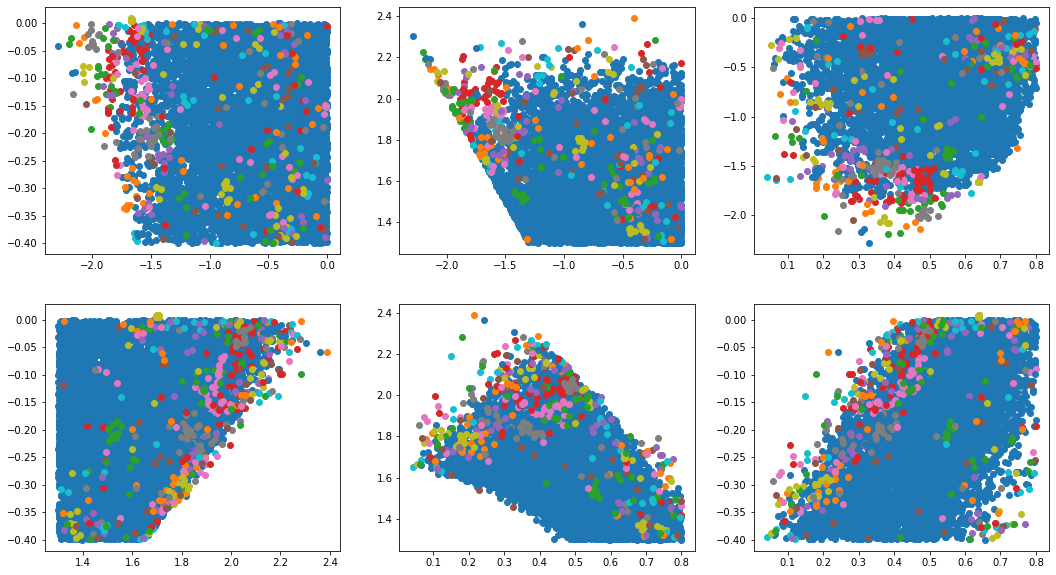

0.07
108.0


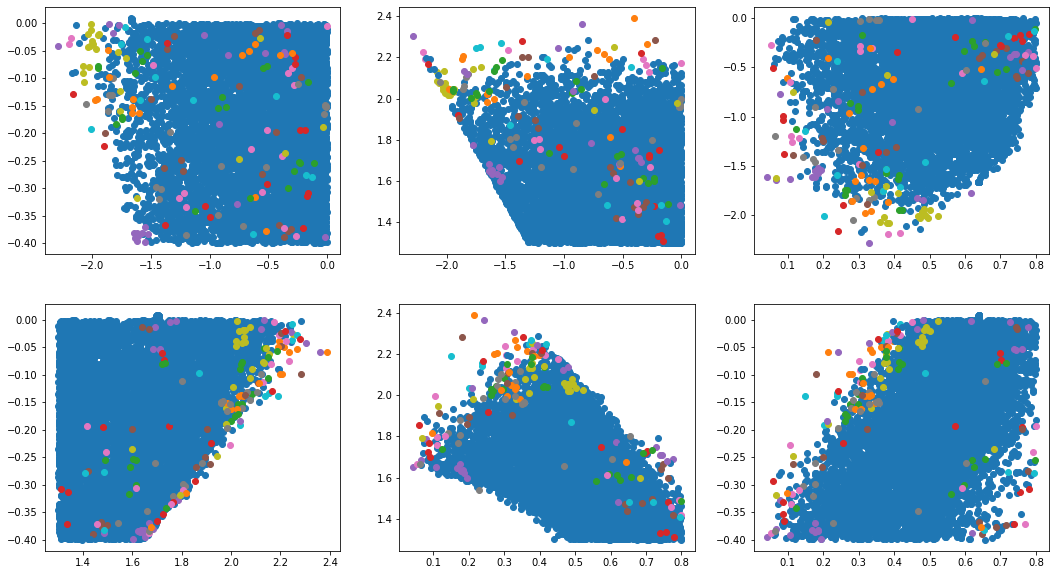

0.08
59.0


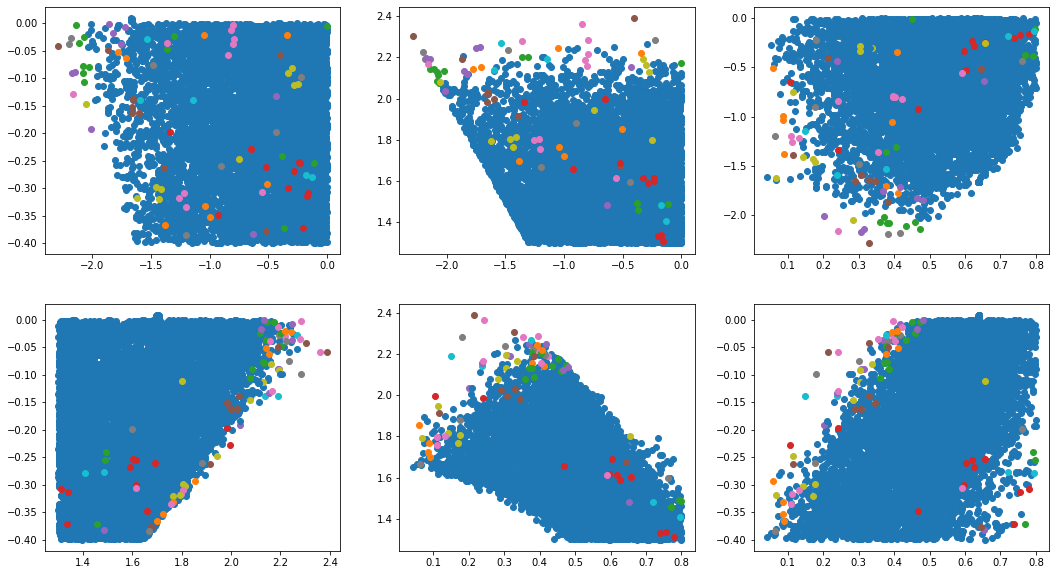

0.09
34.0


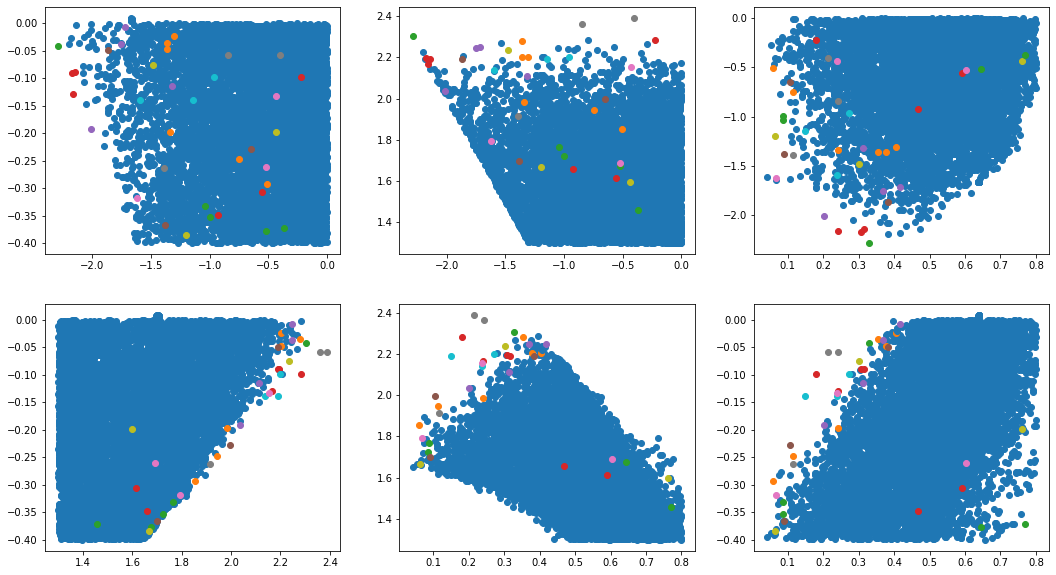

0.1
22.0


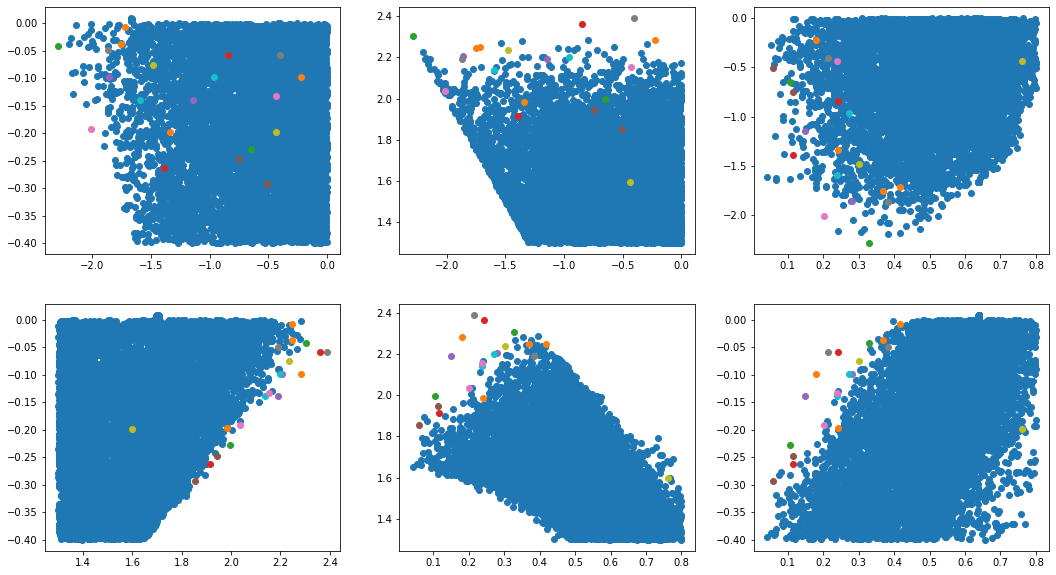

In [23]:
# Single Linkage Method Results
for i in n_SL:
        DTresh = i
        print(DTresh)
        string = 'SimWB_SL_labels'+str(DTresh)+'.csv'
        SL_labels = np.loadtxt(string , delimiter=',')
        mx = np.max(SL_labels)
        print(mx+1)
        plt.rcParams.update({'font.size':10})
        fig, ax = plt.subplots(2, 3, figsize=(18,10))
        for i in np.arange(mx+1):
            mask = (SL_labels == i)
            plotClust(dataWB[mask])
        plt.show()

In [24]:
# Ward Method
n_W = [0.07,0.1,1,2,3,4,5,5.2]
for i in  n_W:
        DTresh = i
        Wclustering = AgglomerativeClustering(n_clusters=None, linkage='ward', distance_threshold=DTresh).fit(dataWB)
        Ward_labels = Wclustering.labels_
        string = 'SimWB_Ward_labels'+str(DTresh)+'.csv'
        np.savetxt(string, Ward_labels , delimiter=',')

0.07


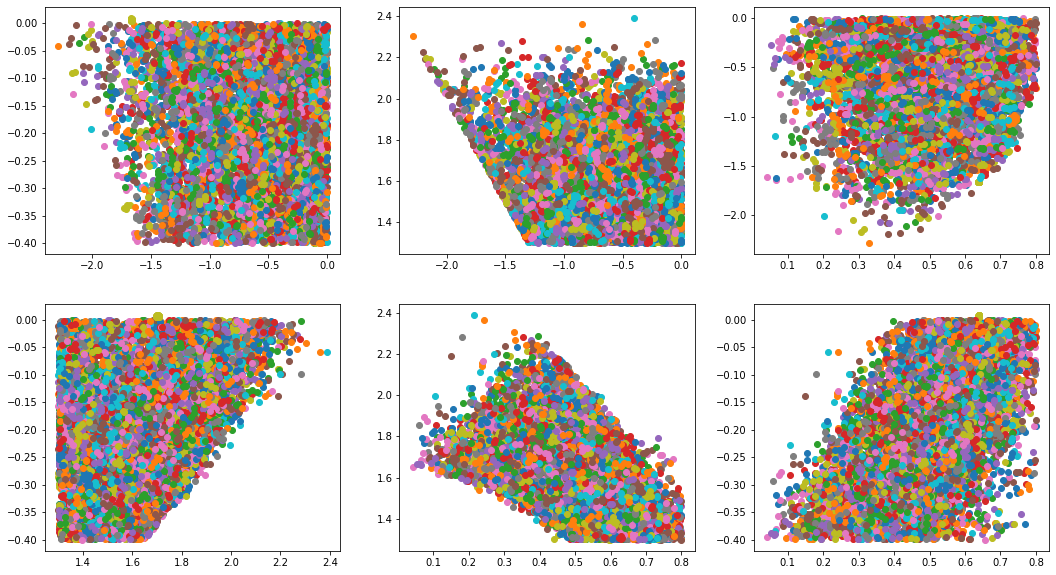

0.1


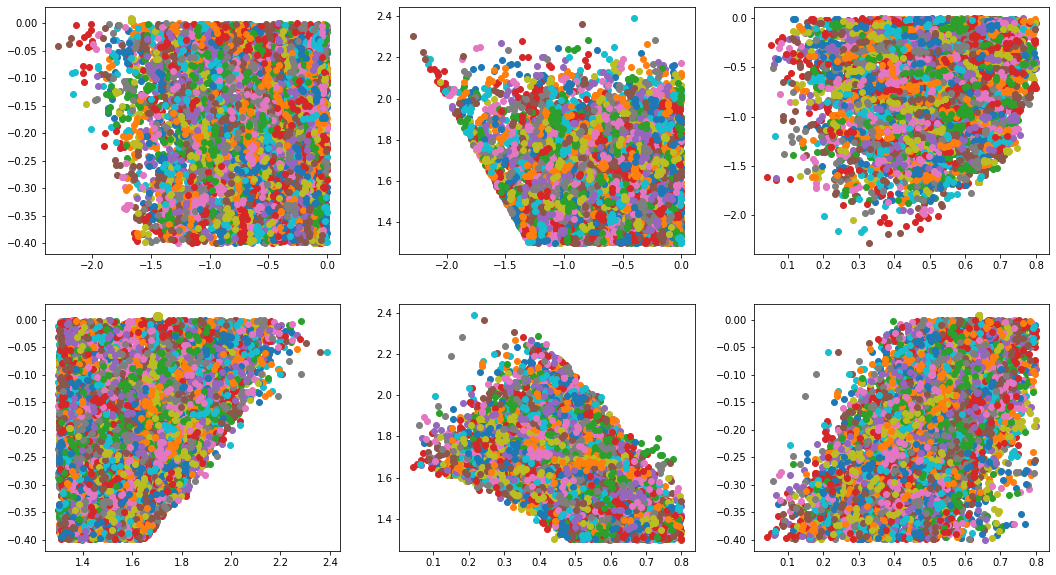

1


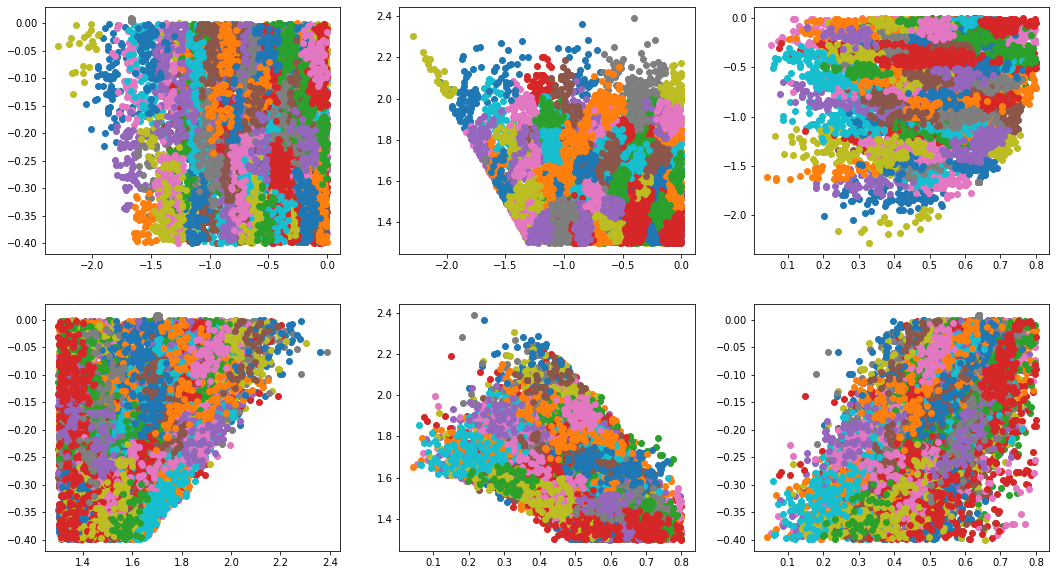

2


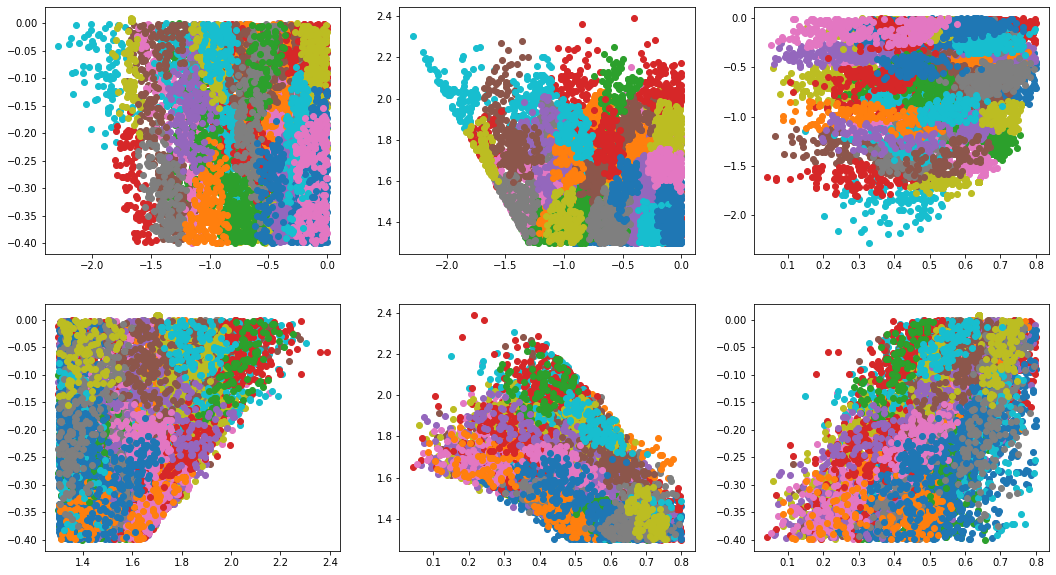

3


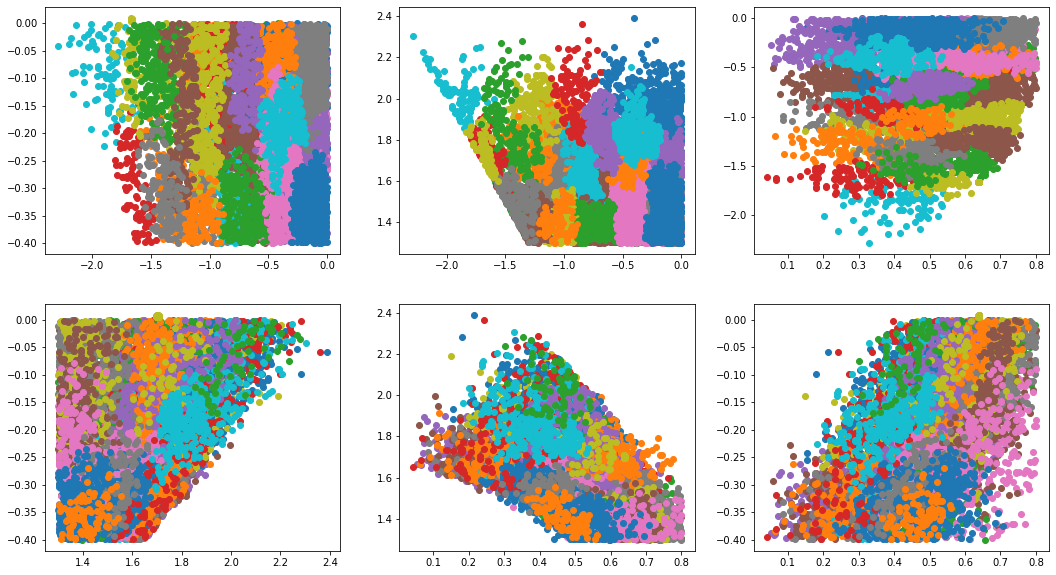

4


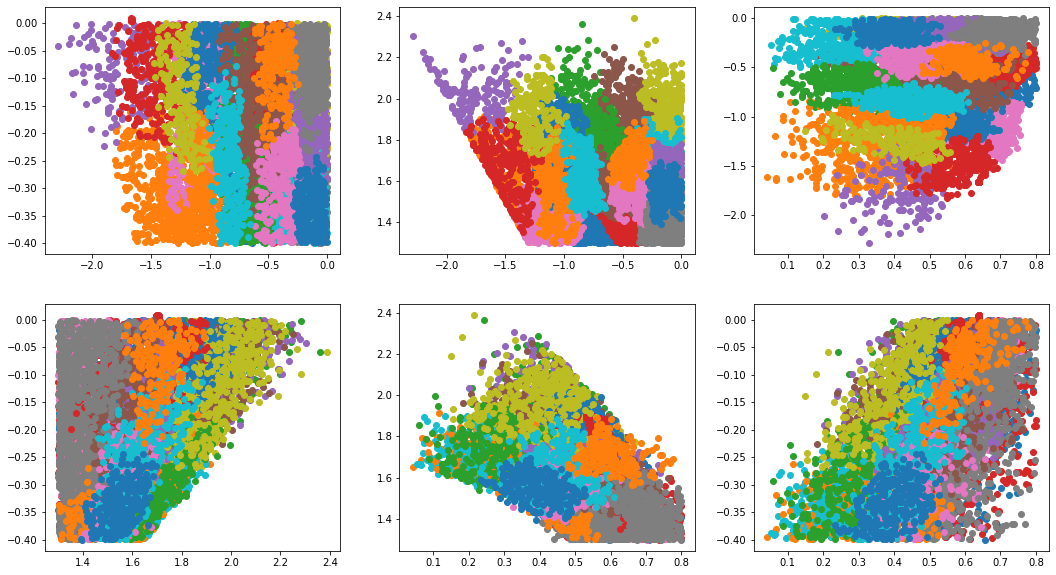

5


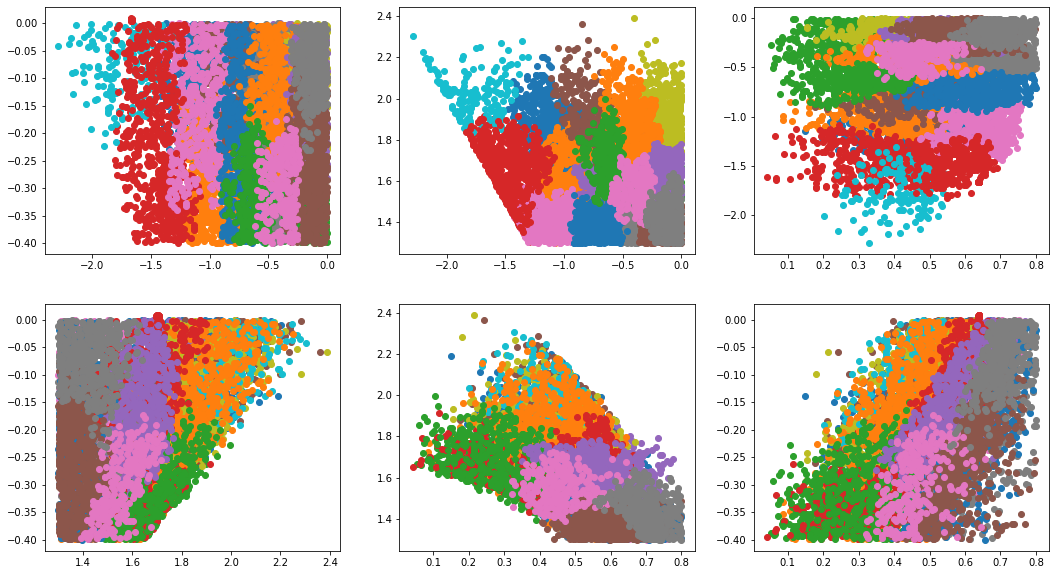

5.2


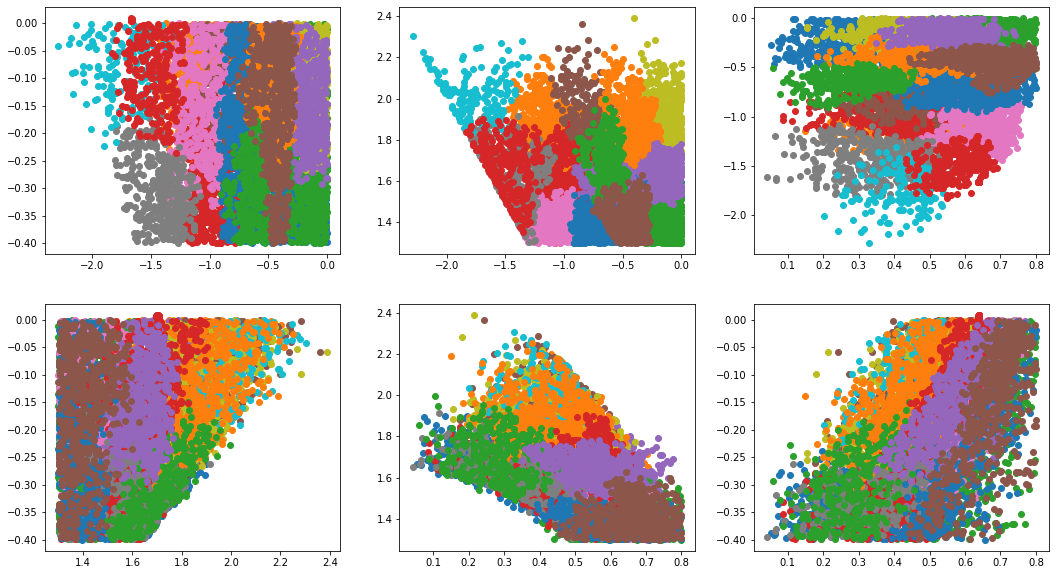

In [25]:
# Ward Method Results
for i in n_W:
        DTresh = i
        print(DTresh)
        string = 'SimWB_Ward_labels'+str(DTresh)+'.csv'
        W_labels = np.loadtxt(string , delimiter=',')
        mx = np.max(W_labels)
        plt.rcParams.update({'font.size':10})
        fig, ax = plt.subplots(2, 3, figsize=(18,10))
        for i in np.arange(mx+1):
            mask = (W_labels == i)
            plotClust(dataWB[mask])
        plt.show()

In [26]:
# DBScan Method
n_DB = [0.001,0.01,0.1,0.1] # best at 0.01
for i in n_DB:
        eps = i
        db = DBSCAN(eps=eps, min_samples=20).fit(dataWB)
        DB_labels = db.labels_
        string = 'SimWB_DB_labels'+str(eps)+'.csv'
        np.savetxt(string, DB_labels , delimiter=',')

0.001


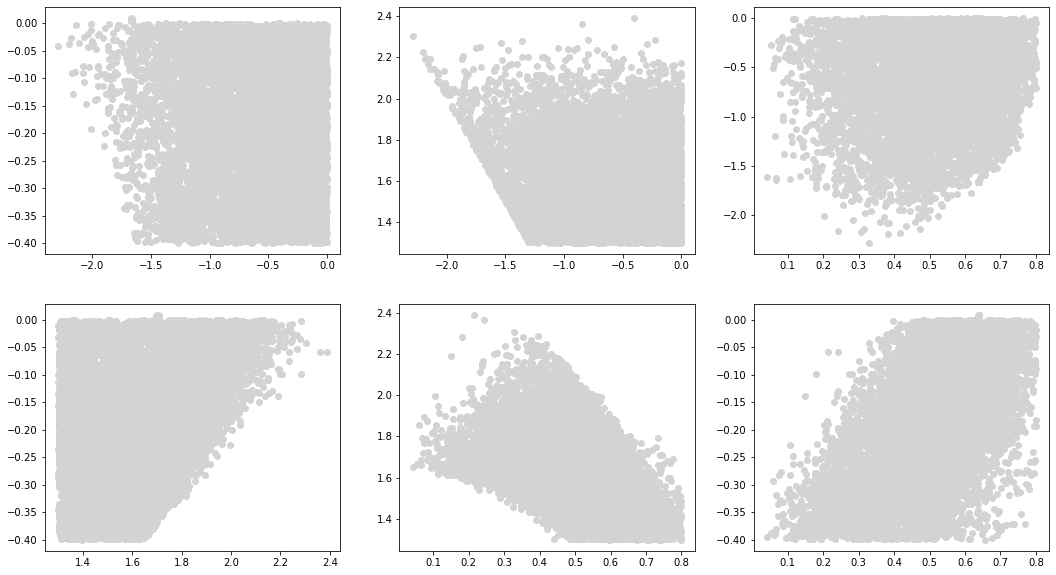

0.01


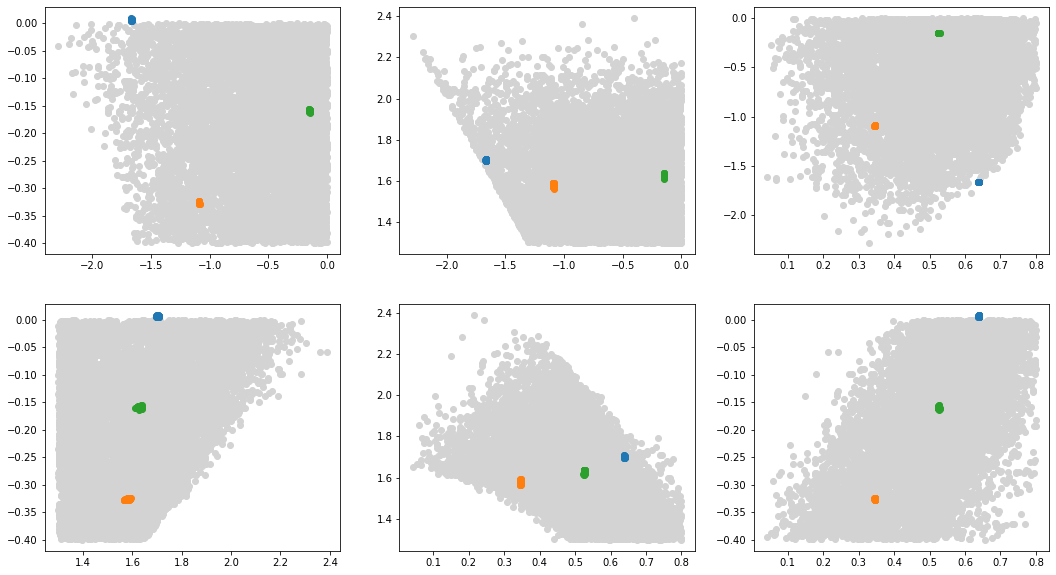

0.1


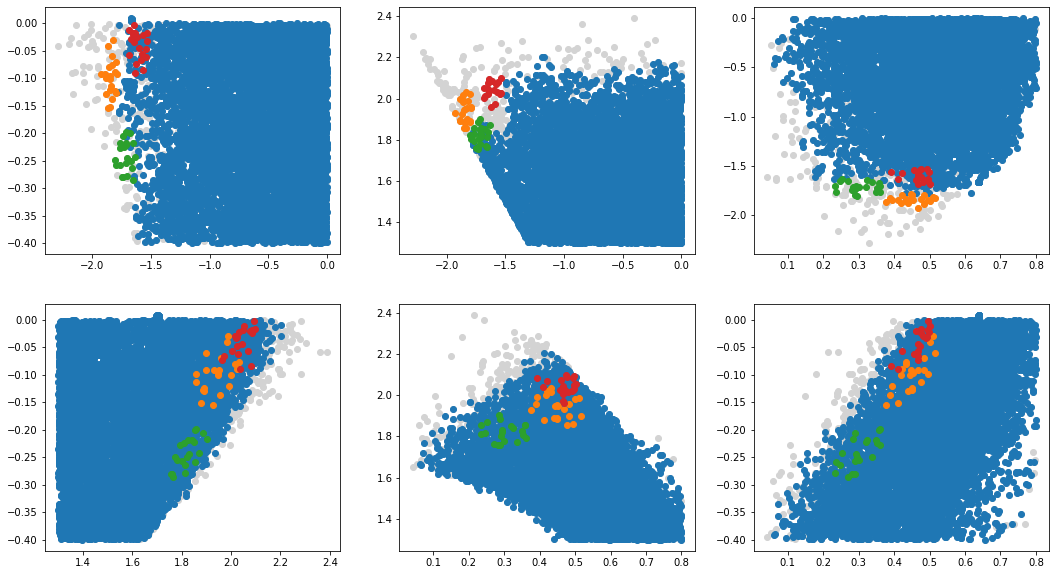

0.1


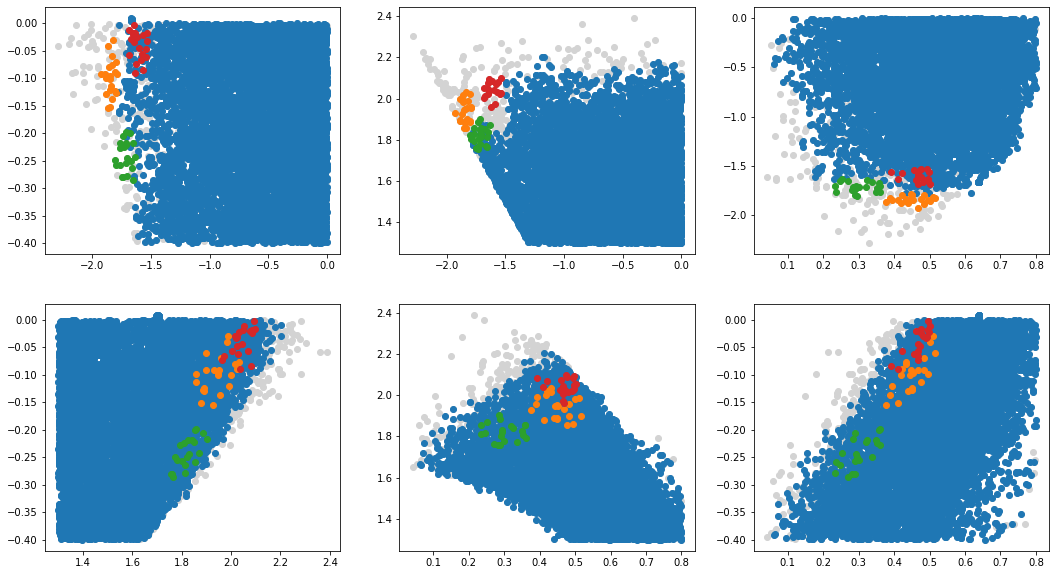

In [27]:
# DBScan Method Results
for i in n_DB:
        eps = i
        print(eps)
        string = 'SimWB_DB_labels'+str(eps)+'.csv'
        DB_labels = np.loadtxt(string , delimiter=',')
        mx = np.max(DB_labels)
        plt.rcParams.update({'font.size':10})
        fig, ax = plt.subplots(2, 3, figsize=(18,10))
        plotClust2(dataWB, 'lightgrey')
        for i in np.arange(mx+1):
            mask = (DB_labels == i)
            plotClust(dataWB[mask])
        plt.show()

In [28]:
# OPTICS Method
n_opt=[0.01,0.1,0.5,0.8,0.9] #  0.5 gives best results
for i in n_opt:
        xi = i
        opt = OPTICS(xi=xi, min_samples=20).fit(dataWB)
        OPT_labels = opt.labels_
        string = 'SimWB_OPT_labels'+str(xi)+'.csv'
        np.savetxt(string, OPT_labels , delimiter=',')

0.01


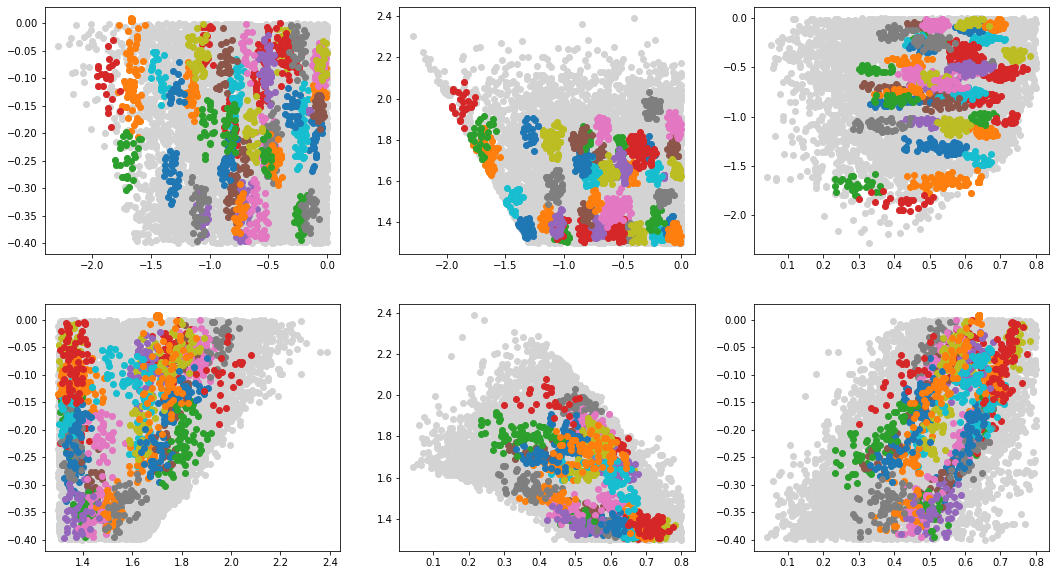

0.1


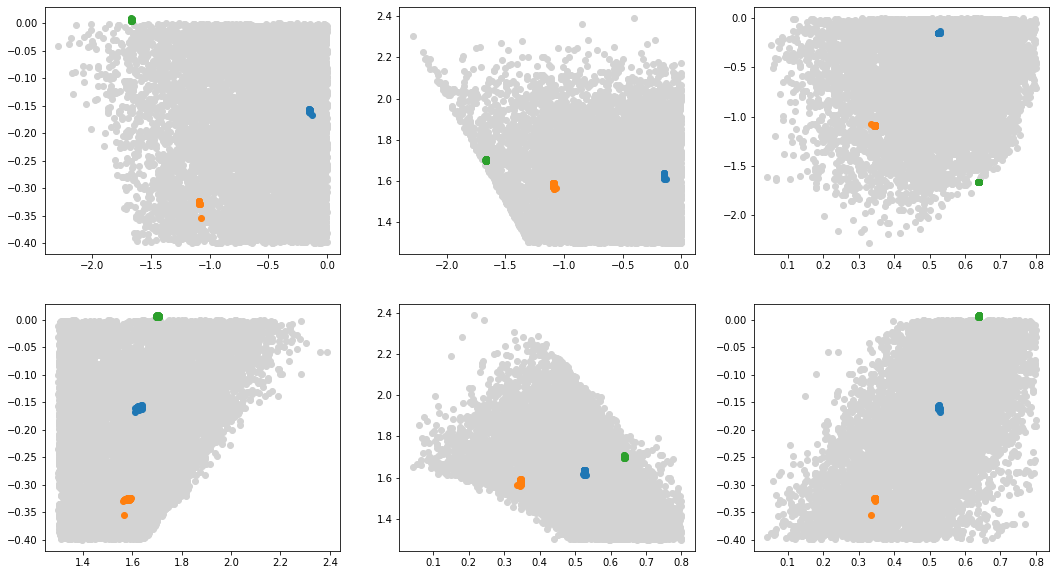

0.5


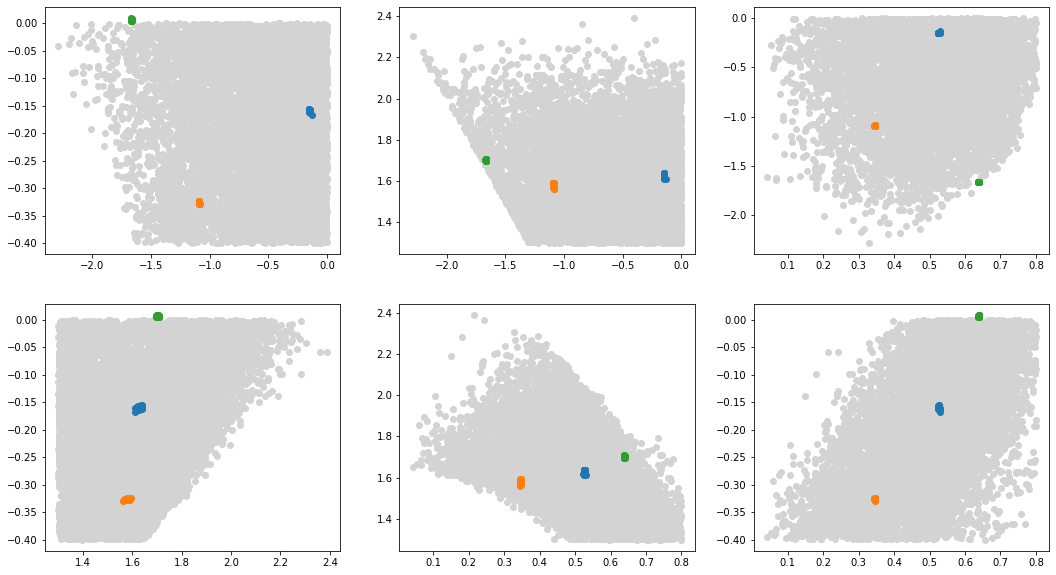

0.8


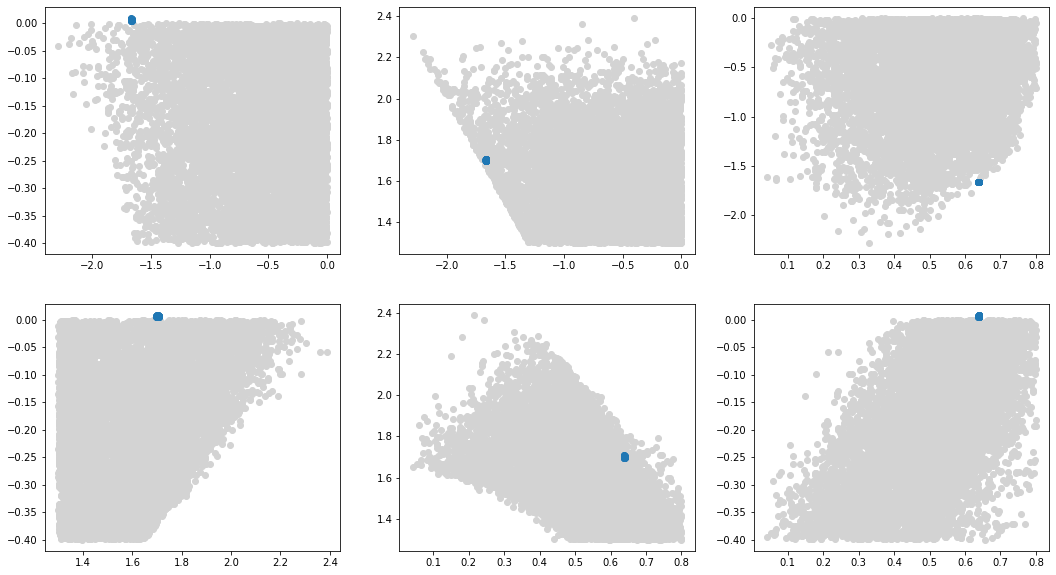

0.9


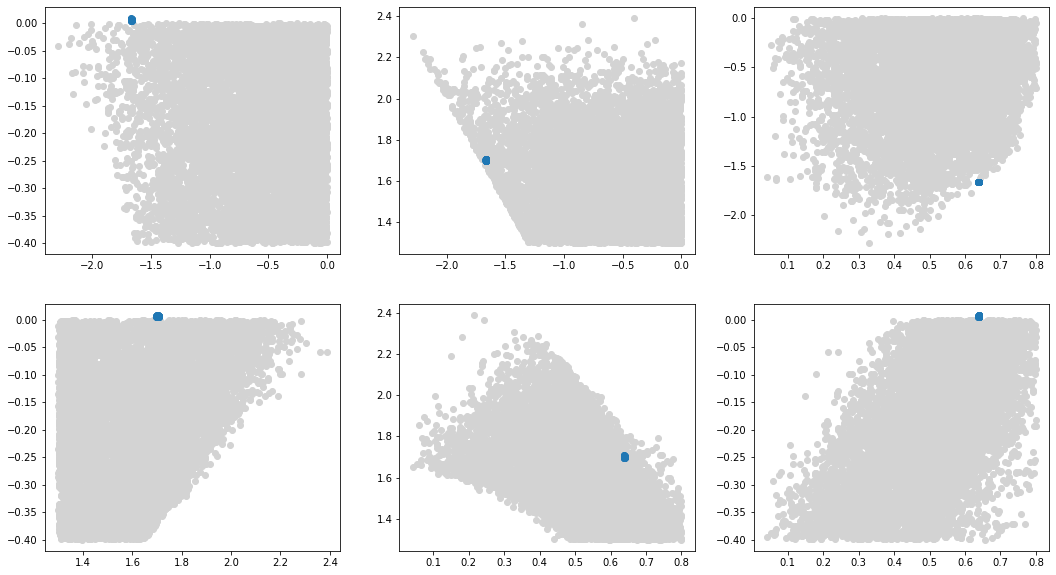

In [29]:
# OPTICS Method Results
for i in n_opt:
        xi = i
        print(xi)
        string = 'SimWB_OPT_labels'+str(xi)+'.csv'
        OPT_labels = np.loadtxt(string , delimiter=',')
        mx = np.max(OPT_labels)
        plt.rcParams.update({'font.size':10})
        fig, ax = plt.subplots(2, 3, figsize=(18,10))
        plotClust2(dataWB, 'lightgrey')
        for i in np.arange(mx+1):
            mask = (OPT_labels == i)
            plotClust(dataWB[mask])
        plt.show()